In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
# %cd drive/MyDrive/Colab_Notebooks/Image_Classification/Covid19-dataset

# Chest X-Ray Image Classification

This project intends to explore different `scikit-learn` models and their accuracy of predicting whether a person's chest x-ray suggests that they are healthy, have Covid-19, or viral pneumonia. Two datasets are used: [training data](https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia) and [holdout data](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset).

The project explores three different models, SVM, decision trees, and neural nets. 

In [63]:
import cv2
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
import random
import pickle 

# Data preprocessing
# from sklearn.preprocessing import OneHotEncoder

# General result validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Scaling Data and Cross-Validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# SVC model
from sklearn.svm import SVC

# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

# Neural Net Model
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

simplefilter(action = 'ignore', category = ConvergenceWarning)

# Regression Tree Model
from sklearn.tree import DecisionTreeRegressor


## Data Exploration:

For this project, the data takes the form of images, which can be manipulated a limited number of ways. To keep things simple, this project will simply ensure that images will be converted into a form that Scikit-Learn algorithms can handle. 

### Step 1: Data Collection

The data from the Kaggle dataset is already cleaned, with "clusters of defective images are removed during the curation process and a refined dataset is obtained which is available for download." All that is left to do regarding the data is to collect it and reshape it into a way that can be processed by the SVM classifier.

This involves:
* Assigning labels
* Reading and resizing images 
* Flattening images 

It is imperative to resize the images, as processing very large images can be difficult, especially if we're treating each pixel as a feature. Also, flattening the images (2D array) into a 1D array makes it possible to pass into a SVM classifier.

#### 1A. Assigning labels
Function to return a label associated with a given path. If the path does not exist, raise an `exception`

In [4]:
def get_label_from_path(path):
    if "COVID-19" in path:
        return "Covid"
    elif "Normal" in path:
        return "Normal"
    elif "Pneumonia-Viral" in path:
        return "Pneumonia-Viral"
    else:
        raise Exception("Path does not contain a valid feature label: ", path)

#### 1B. Reading and Resizing Images
Function to read images from a folder given a path and resize them

In [5]:
def collect_images(path, total_features, total_labels):
    temp_files = []
    [temp_files.extend(glob.glob(path + '*.' + e)) for e in ext]
    temp_images = [cv2.imread(file) for file in temp_files]
    resized_images = []
    for image in temp_images:
        resized_images.append(cv2.resize(image, (100, 100)))
        total_labels.append(get_label_from_path(path))
    total_features.extend(resized_images)

Utilize the `collect_images` and `get_label_from_path` methods to read in images from the **Curated-dataset**.

Keep a collection of all the images and their features.

Temporarily keep a train and test split (80-20) to model a small classifier later.

In [6]:
train_paths = ["Curated-dataset/COVID-19/", "Curated-dataset/Normal/", "Curated-dataset/Pneumonia-Viral/"]
# test_paths = ["test/Covid/", "test/Normal/", "test/Viral_Pneumonia/"]
ext = ['png', 'jpg', 'jpeg']    # Add image formats here
all_images = []
all_labels = []

# Collect all images from Curated-dataset
for path in train_paths:
    collect_images(path, all_images, all_labels)

# After collecting all images, randomize them
temp_arr = []
for i in range(len(all_images)):
    temp_arr.append((all_images[i], all_labels[i]))
random.shuffle(temp_arr)
for i in range(len(all_images)):
    all_images[i] = temp_arr[i][0]
    all_labels[i] = temp_arr[i][1]

# Temporarily keep a partition of training data and testing data
FIFTH_OF_DATA = int(0.2 * len(all_images))
train_images = all_images[: 4 * FIFTH_OF_DATA]
train_labels = all_labels[: 4 * FIFTH_OF_DATA]
test_images = all_images[4 * FIFTH_OF_DATA:]
test_labels = all_labels[4 * FIFTH_OF_DATA:]

Verify the dimensions of the data

In [7]:
print("Training data: ", len(train_images), len(train_labels))
print("Testing data: ", len(test_images), len(test_labels))
print("All data: ", len(all_images), len(all_labels))

Training data:  4964 4964
Testing data:  1243 1243
All data:  6207 6207


Function that prints out the avg dimensions of a set of images.

In [8]:
def print_dimensions(images):
    average_x = 0
    average_y = 0
    min_x = 1000000
    min_y = 1000000
    train_len = len(images)
    for image in images:
        dimension = image.shape
        average_x += dimension[0]
        min_x = min(min_x, dimension[0])
        if(len(dimension) > 1):
            average_y += dimension[1]
            min_y = min(min_y, dimension[1])
        print("Average width: ", average_x / train_len)
        print("Min width: ", min_x)
        if(len(dimension) > 1):
            print("Average height: ", average_y / train_len)
            print("Min height: ", min_y, "\n")

Ensure that the images have been resized correctly to be *100x100*

In [14]:
# print("Train image information: ")
# print_dimensions(train_images)

Visualize a few of the training images to see what the computer would see. An observation is that the general shapes of things remain intact and are not particularly distorted. Some details may be obfuscated.

<class 'numpy.ndarray'>


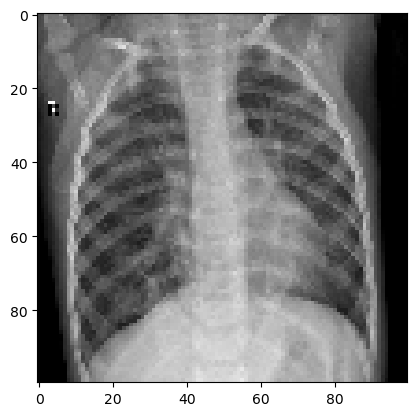

<class 'numpy.ndarray'>


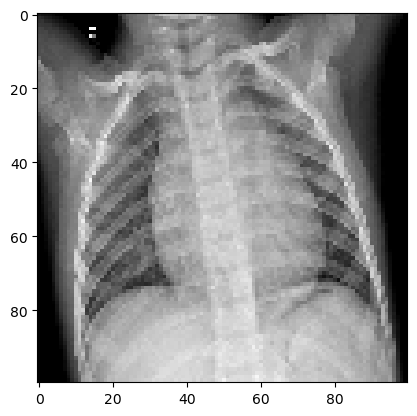

<class 'numpy.ndarray'>


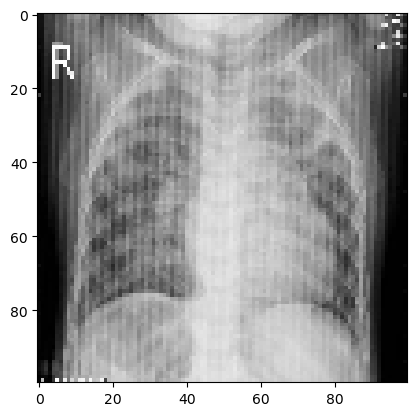

In [10]:
for i in range(3):
    random_img = random.choice(train_images)
    print(type(random_img))
    plt.imshow(random_img, interpolation='nearest')
    plt.show()

#### 1C. Flattening Images

Create a method to flatten an array of images. Apply that to `train_images`, `test_images`, and `all_images`

Function to flatten collection of 2D arrays into 1D arrays

In [11]:
def flatten_images(images):
    for i in range(len(images)):
        images[i] = np.reshape(images[i], -1)

## Model: SVM Classifier

The first model to explore is the SVM classifier. Characteristics of SVM classifiers include:
* **Not** susceptible to the curse of dimensionality
* Always possible to find an optimal solution
* Data needs to be scaled
* Hyperparameters can be tuned with cross-validation

### Step 1: Cross-Validation

To find the best parameters and verify the process of using an SVM classifier, we will use cross-validation. 

This involves:
* Creating a Pipeline for the data
* Running a nested cross-validation loop
* Creating a final model

We need to create a pipeline to try different ways to scale the data, different ways to project features to lower dimensions, and try different classifiers. The nested cross-validation loop will help verify the accuracy of the classifier and partition the data automatically. Once the process has been deemed valid, we can create a final model.

#### 1A. Create a Pipeline for the Data

Create a StandardScaler object, PCA object, and Pipeline which takes the aforementioned objects. These will be used with a param grid that will try pca `__n_components` from 5-18 and svc `__kernel`'s, `linear`, `rbf`, and `poly`. These will be passed into a `GridSearchCV` object to create the inner-loop of the cross-validation loop with folds = 5. 

In [12]:
# flatten each collection of images
flatten_images(train_images)
flatten_images(test_images)
flatten_images(all_images)

scaler = StandardScaler()
pca = PCA()
svc_classifier = SVC()
svc_pipeline = Pipeline(steps = [('scaler', scaler), 
                                 ('pca', pca), 
                                 ('svc', svc_classifier)])

svc_param_grid = {
    'pca__n_components': list(range(5, 19)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}

#### 1B. Run Nested Cross-Validation Loop

Pass the inner_svm, which is scaled, using PCA, and will try various params into a `cross_val_score`, which will produce the results of the outer cross-validation loop with folds = 5. Pass in the entire dataset, as these methods will automatically partition the data. This will take a decent amount of time, as there are 10,000 features per image (100 x 100), and the number of models to train.

When it's complete, print the average accuracy.

In [36]:
# Test a singular classifier trained on a single partition
svc_classifier.fit(train_images, train_labels)
predictions = svc_classifier.predict(test_images)
print("Accuracy with holdout: ", 
      accuracy_score(test_labels, predictions))

# Create the inner cross-validation loop with a cv = 5
inner_svm = GridSearchCV(svc_pipeline, svc_param_grid, cv = 5)
# Run outer cross-validation loop with cv = 5
fold_accuracies = cross_val_score(inner_svm, 
                                  all_images, 
                                  all_labels, 
                                  cv = 5)
print("Svc accuracy: ", sum(fold_accuracies) / len(fold_accuracies))

Accuracy with holdout:  0.9517296862429606
Svc accuracy:  0.9347525046680707


#### 1C. Create a Final Model

Given that the cross-validation loop had a relatively high accuracy, it is safe to say that the SVM model is appropriate for classifying X-ray images. Fit the inner-loop on all the data, and display the best hpyerparameters and its overall accuracy.

In [37]:
final_svc = GridSearchCV(svc_pipeline, svc_param_grid, cv = 5)
final_svc.fit(all_images, all_labels)

print("Best_params: ", final_svc.best_params_)
print("Accuracy: ", final_svc.best_score_)
filename = 'final_svc_model.sav'

Best_params:  {'pca__n_components': 18, 'svc__kernel': 'rbf'}
Accuracy:  0.9347525046680707


#### Important!
Dump final model to save a lot of work!

In [38]:
pickle.dump(final_svc, open(filename, 'wb'))

### Step 2: Testing Model on Unseen Data
It's important for our model to be accurate on unseen data. Otherwise, our model is not very useful, as it is unfit for evaluating new data. Thus, the next step is to test it on another [dataset](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset), and evaluate its performance thusly.

We can evaluate its effective accuracy through:
* Confusion Matrix
* F-Score
* General Accuracy

In [13]:
# Load in the images from the holdout set
holdout_paths = ["Covid19-dataset/test/COVID-19/", 
                 "Covid19-dataset/test/Normal/", 
                 "Covid19-dataset/test/Pneumonia-Viral/",
                 "Covid19-dataset/train/COVID-19/",
                 "Covid19-dataset/train/Normal/",
                 "Covid19-dataset/train/Pneumonia-Viral/"]
holdout_images = []
holdout_labels = []
for path in holdout_paths:
    collect_images(path, holdout_images, holdout_labels)
flatten_images(holdout_images)

In [21]:
# Load the saved model for SVC
filename = 'final_svc_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

#### 2A. Confusion Matrix
Flatten the holdout images and display the Confusion Matrix given the holdout labels and predictions.

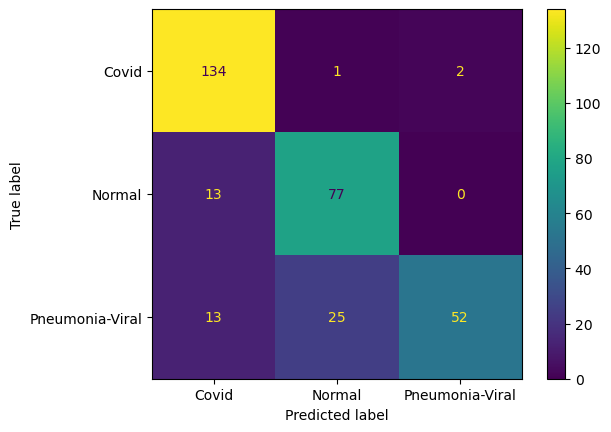

In [16]:
predictions = loaded_model.predict(holdout_images)
ConfusionMatrixDisplay.from_predictions(holdout_labels, predictions)

#### 2B. F-Score
Display the F-score of the model.

In [20]:
f_score = f1_score(holdout_labels, predictions, average = 'weighted')
print("F score: ", f_score)

F score:  0.8215658268942786


#### 2C. General Accuracy
Display the percentage of records that the model predicts correctly.

In [33]:
accuracy = accuracy_score(holdout_labels, predictions)
print("Total accuracy on different dataset: ", accuracy * 100, "%")

Total accuracy on different dataset:  82.96529968454259 %


### Conclusion for SVM Classifiers

The SVM classifiers seem to do a good job at classifying whether someone has Covid-19, viral pneumonia, or is healthy given a large number X-ray images to train on. It took a few hours to do the cross-validation, and that could probably be decremented by resizing the images to smaller dimensions at the expense of some accuracy. 

One problematic thing with the model's prediction is that it has a non-trivial amount of false-negatives for viral pneumonia. This possibly be countered if we applied a cost matrix that punished false-negatives.

When viewing the F-score of the model, which a harmonic mean of precision and recall, we can see that it is about 0.82. We used `weighted` average to calculate the f1_score, as not all of the class labels were evenly distributed. This F-score is fairly good.

## Model: Decision Tree

Decision trees are a type of supervised classifier that try to find ways to split the data with hyperplanes to decrease the entropy of the data into increasingly homogeneous groups. Decision Trees are a good choice for classifying images because:

* They are fast
* They are not affected by the curse of dimensionality
* Data does not need to be scaled
* Can handle multiple outputs

### Step 1: Cross-Validation

To find the best parameters and verify the process of using an Decision Tree classifier, we will use cross-validation. 

This involves:
* Creating a Classifier for the data
* Running a nested cross-validation loop
* Creating a final model

We need to create a pipeline to try different ways to scale the data, different ways to project features to lower dimensions, and try different classifiers. The nested cross-validation loop will help verify the accuracy of the classifier and partition the data automatically. Once the process has been deemed valid, we can create a final model.

#### 1A. Creating a Parameter Grid

Simply create a decision tree classifier and some parameters to try for the inner-cross validation. We will try `dtc__max_depth` ranging from 5-20 in increments of 5, `dtc__min_samples_leaf` ranging from 5-20 with increments of 5, and `dtc__max_features` ranging from 5-15 with increments of 5.

In [48]:
dtc = DecisionTreeClassifier()
tree_params = {'max_depth': list(range(5, 21, 5)), 
               'min_samples_leaf': list(range(5, 21, 5)), 
               'max_features': list(range(5, 16, 5))}
inner_dtc = GridSearchCV(dtc, tree_params, cv = 5)

#### 1B. Cross-Validation Score

Put the GridSearchCV within a `cross_val_score` with `cv = 5`. This will constitute the outer cross-validation loop. Display the accuracy. 

In [49]:
dtc_cross_accuracy = cross_val_score(inner_dtc, all_images, all_labels, cv = 5)

In [50]:
print("Accuracy for dtc: ", sum(dtc_cross_accuracy) / len(dtc_cross_accuracy))

Accuracy for dtc:  0.8293839963356131


#### 1C. Creating a Final Model

Fit the decision tree model with all of the images and their respective labels. Save this model to a file called `final_dtc_model.sav`. This will save a good amount of time!

In [51]:
dtc_final_model = GridSearchCV(dtc, tree_params, cv = 5)
dtc_final_model.fit(all_images, all_labels)
filename = 'final_dtc_model.sav'
pickle.dump(dtc_final_model, open(filename, 'wb'))

### Step 2: Testing Model on Unseen Data

Again, to avoid data leakage, we do not use the holdout set to train the model. We can get a good idea of how well our model is trained by testing it on some independent dataset.

We can evaluate its effective accuracy through:
* Confusion Matrix
* F-Score
* General Accuracy

In [52]:
# Load the saved model for Decision Tree
filename = 'final_dtc_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

#### 2A. Confusion Matrix
Flatten the holdout images and display the Confusion Matrix given the holdout labels and predictions.

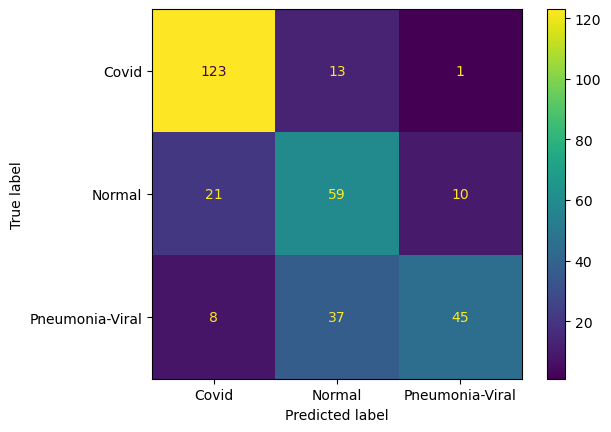

In [53]:
predictions = loaded_model.predict(holdout_images)
ConfusionMatrixDisplay.from_predictions(holdout_labels, predictions)

#### 2B. F-Score
Display the F-Score of the model

In [54]:
f_score = f1_score(holdout_labels, predictions, average = 'weighted')
print("F score: ", f_score)

F score:  0.7112372340084104


#### 2C. General Accuracy
Display the percentage of records that the model predicts correctly.

In [55]:
dtc_final_model = pickle.load(open(filename, 'rb'))
dtc_predictions = dtc_final_model.predict(holdout_images)
dtc_accuracy = accuracy_score(holdout_labels, dtc_predictions)
print("Total accuracy on different dataset: ", dtc_accuracy * 100, "%")

Total accuracy on different dataset:  71.60883280757098 %


### Conclusion for Decision Tree

The Decision Tree Classifier was used because it is resistant to the curse of dimensionality. It was relatively fast to train (~20 minutes, compared to 3+ hours for Neural Nets). However, its practical advantages stop there, as its accuracy is quickly diminished.

Its general accuracy is notably lower than the SVM (73.19% compared to 82.97%). Its F-score is also about 10 points lower. Like the SVM classifier, the decision tree classifier struggled to identify cases of viral pneumonia correctly. With nearly have the cases of viral pneumonia resulting in a false negative, this is a serious issue, where we could use a cost matrix to solve. Overall, this classifier is good for a "quick and dirty" way to diagnose Covid-19, but not so for anything else.

## Model: Neural Net

Neural nets are a type of supervised classifier that utilize forward and back propogation to update a series of hidden layer weights to classify certain records. Neural nets are suitable for this type of thing because:

* Neural nets can adapt to complex decision boundaries
* Not susceptible to curse of dimensionality (in making decisions but is affected when considering time to train)

However, we should be wary, as neural nets are typically expensive to train, may be subject to overfitting, and are difficult to understand.

#### 1A. Creating a Pipeline

First, make a classifier and a scaling pipeline for the nerual net. We will make a parameter grid for the neural net, try hidden layers of sizes (30, 40, 50, 60) and activation functions `logistic`, `tanh`, and `relu`. 

In [15]:
nn_classifier = MLPClassifier()
nn_pipe = Pipeline(steps = [('scaler', StandardScaler()), ('NN', nn_classifier)])

nn_param_grid = {
    'NN__hidden_layer_sizes': [(30,), (40,), (50,), (60,)],
    'NN__activation' : ['logistic', 'tanh', 'relu']
}

inner_nn = GridSearchCV(nn_pipe, nn_param_grid, cv = 5)

#### 1B. Cross Validation
Put the GridSearchCV inside a `cross_val_score` with `cv = 5`. This will tell us the accuracy of the process. 

In [16]:
outer_nn_score = cross_val_score(inner_nn, all_images, all_labels, cv = 5)

In [17]:
print("Accuracy for Neural Net: ", sum(outer_nn_score) / len(outer_nn_score))

Accuracy for Neural Net:  0.9503796091926281


#### 1C. Final Model

Since the average `cross_val_score` was quite good (0.95), we can go ahead and train a final model by fitting the model with all the images and data. 

In [23]:
nn_final_model = GridSearchCV(nn_pipe, nn_param_grid, cv = 5)
nn_final_model.fit(all_images, all_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('NN', MLPClassifier())]),
             param_grid={'NN__activation': ['logistic', 'tanh', 'relu'],
                         'NN__hidden_layer_sizes': [(30,), (40,), (50,),
                                                    (60,)]})

In [28]:
filename = 'final_nn_model.sav'
pickle.dump(nn_final_model, open(filename, 'wb'))

### Step 2: Testing Model on Unseen Data

Load the final model. Again, we will test how good the final model is on some kind of holdout set.

We can evaluate its effective accuracy through:
* Confusion Matrix
* F-Score
* General Accuracy

In [35]:
filename = 'final_nn_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
print("Best params: ", loaded_model.best_params_)
print("Best score: ", loaded_model.best_score_)

Best params:  {'NN__activation': 'relu', 'NN__hidden_layer_sizes': (40,)}
Best score:  0.9515076019157581


#### 2A. Confusion Matrix
Flatten the holdout images and display the Confusion Matrix given the holdout labels and predictions.

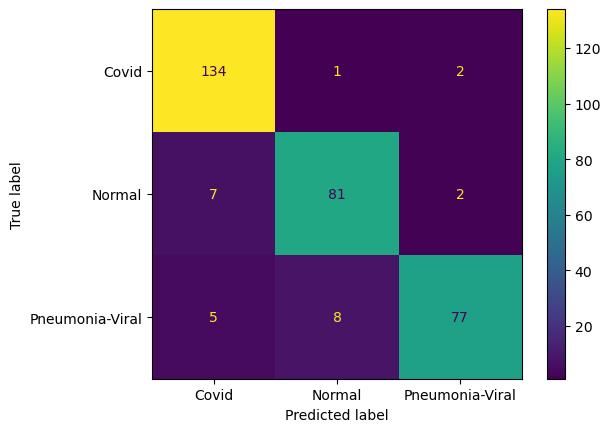

In [36]:
predictions = loaded_model.predict(holdout_images)
ConfusionMatrixDisplay.from_predictions(holdout_labels, predictions)

#### 2C. F-Score
Display the F-Score of the model

In [37]:
f_score = f1_score(holdout_labels, predictions, average = 'weighted')
print("F-score: ", f_score)

F score:  0.9204768059306229


#### 2C. General Accuracy
Display the percentage of records that the model predicts correctly.

In [31]:
nn_predictions = nn_final_model.predict(holdout_images)
nn_accuracy = accuracy_score(holdout_labels, nn_predictions)
print("Total accuracy on different dataset: ", nn_accuracy * 100, "%")

Total accuracy on different dataset:  92.11356466876973 %


### Conclusion for Neural Nets

Neural Nets yielded excellent results for classifying patients of all classes. The general accuracy was 92.11%, and the F-score was comparatively high, at 0.92. This means that there were relatively few misclassifications for both false-positives and false-negatives. This can be seen in the confusion matrix, where a significant amount of predictions aligned with the true labels along the diagonal. In cases with Covid-19, only 3/137 (2.2%) of cases were misclassified. The results are comparably good for healthy patients with 9/90 (10%) and viral pneumonia patients with 13/90 (14.4%) of misclassifications.

While the model took around 4 hours to train (roughly the same amount of time as the SVM classifier) the neural net had better results. In medical cases where false negatives are dangerous, this neural net model is more reliable than the SVM and decision tree classifier models.

## Model: Regression Tree

Regression Trees are just like Decision Trees, except we swap out the impurity metric to something that makes sense for a continuous target variable (like SSE), and we make our predictions based on an average of y-values of datapoints in each leaf. We will use this because:

* They are fast to train
* Since a probability is given, perhaps we can see which classifications give our model trouble!

In [67]:
def encode_labels(labels):
    encoded_labels = []
    for label in labels:
        if label == 'Covid':
            encoded_labels.append([1, 0, 0])
        elif label == 'Normal':
            encoded_labels.append([0, 1, 0])
        else:
            encoded_labels.append([0, 0, 1])
    return encoded_labels

#### 1A. Creating a Parameter Grid

Create a pipeline to make the inner cross-validation loop. Use a `max_depth` from 5-20 in increments of 5, `min_samples_leaf` from 5-20 in increments of 5, and error `criterion`: `square_error`, `friedman_mse`, and `absolute_error`.

In [70]:
rtc = DecisionTreeRegressor()

regression_tree_params = {'max_depth': list(range(5, 21, 5)), 
                          'min_samples_leaf': list(range(5, 21, 5)), 
                          'criterion': ['squared_error', 'friedman_mse', 'absolute_error']}
inner_rtc = GridSearchCV(rtc, regression_tree_params, cv = 5)

encoded_labels = encode_labels(all_labels)

#### 1B. Cross-Validation Score
Put the `GridSearchCV` into a `cross_val_score` with a `cv = 5` to validate the modeling process.

In [ ]:
outer_rtc_score = cross_val_score(inner_rtc, all_images, encoded_labels, cv = 5)
print("Accuracy for Regression Tree: ", sum(outer_rtc_score) / len(outer_rtc_score))

In [ ]:
rtc_final_model = GridSearchCV(rtc, regression_tree_params, cv = 5)
rtc_final_model.fit(all_images, encoded_labels)
filename = 'final_rtc_model.sav'
pickle.dump(rtc_final_model, open(filename, 'wb'))